# Out liers!

In [39]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from keras import layers
from keras import models
import tensorflow as tf
from keras import optimizers
import pickle

## Constantes

In [2]:
MAIN_FOLDER_PATH='C:\\Users\\renat\\Projetos\\Harmful Brain Activity Classification'

TARGETS = ['seizure_vote','lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']

CHAINS = {
    'LL' : [("Fp1","F7"),("F7","T3"),("T3","T5"),("T5","O1")],
    'RL' : [("Fp2","F8"),("F8","T4"),("T4","T6"),("T6","O2")],
    'LP' : [("Fp1","F3"),("F3","C3"),("C3","P3"),("P3","O1")],
    'RP' : [("Fp2","F4"),("F4","C4"),("C4","P4"),("P4","O2")]
}

EEG_COL_NAMES=['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

EEG_DDP_COL_NAMES=['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2',
               'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'EKG']

## Funções

In [33]:
def get_sample(row,metadata,window=True):
    
    eeg_id = str(metadata.loc[row,'eeg_id'])
    eeg_offset = int(metadata.loc[row,'eeg_label_offset_seconds'])
    
    spect_id = str(metadata.loc[row,'spectrogram_id'])
    spect_offset = int(metadata.loc[row,'spectrogram_label_offset_seconds'])
    
    eeg = pd.read_parquet(MAIN_FOLDER_PATH+f'\\train_eegs\\{eeg_id}.parquet')
    spect = pd.read_parquet(MAIN_FOLDER_PATH+f'\\train_spectrograms\\{spect_id}.parquet')
    
    # fill nans with the mean
    
    eeg=eeg.fillna(eeg.mean())
    spect=spect.fillna(spect.mean())
    
    if window:        
        length=10
        eeg = eeg.iloc[(eeg_offset+20)*200:(eeg_offset+30)*200]
        spect = spect.loc[(spect.time>=spect_offset+295)&(spect.time<spect_offset+305)]
        
    else:
        length=50
        eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
        spect = spect.loc[(spect.time>=spect_offset)&(spect.time<spect_offset+600)]
        
    label = metadata.loc[row,TARGETS].values
        
    return eeg, spect, label

def load_data(data,window=True):
    
    eeg_tensor=[]
    sp_tensor=[]
    labels=[]
    
    for row_index in range(data.shape[0]):

        try:
            eeg, spect, label = get_sample(row_index,metadata=data,window=window)       
        except:
            print(f'There was a problem with row {row_index}!')
        else:
            eeg_tensor.append(eeg.values)
            sp_tensor.append(spect.iloc[:,1:].values)
            labels.append(label)
    
    return np.stack(eeg_tensor), np.stack(sp_tensor), np.array(labels)

## Load metadata and select non-overlaping samples

In [4]:
train = pd.read_csv(MAIN_FOLDER_PATH+'\\train.csv')

df=train.groupby('eeg_id')[['spectrogram_id', 'eeg_label_offset_seconds','spectrogram_label_offset_seconds', 'patient_id']].agg({
    'spectrogram_id':'first', 'eeg_label_offset_seconds':'min', 'spectrogram_label_offset_seconds':'min', 'patient_id':'first'})


# normalizing labels

tmp = train.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    df[t] = tmp[t].values
    
y_data = df[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
df[TARGETS] = y_data

tmp = train.groupby('eeg_id')[['expert_consensus']].agg('first')
df['target'] = tmp

df = df.reset_index()

Text(0.5, 1.0, "'df' target distribution")

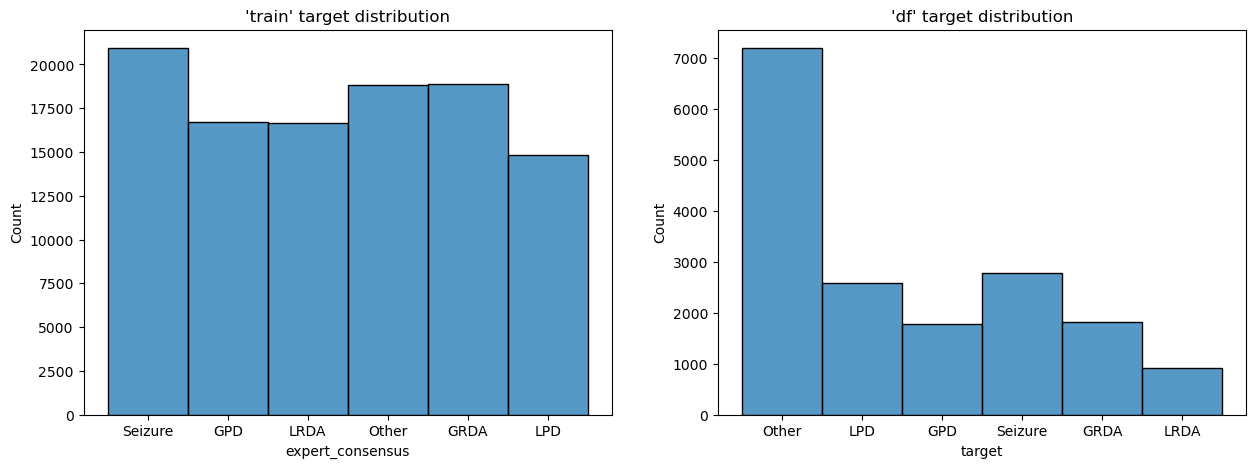

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=train.expert_consensus, ax=ax[0])
ax[0].set_title("'train' target distribution")

sns.histplot(data=df.target, ax=ax[1])
ax[1].set_title("'df' target distribution")

## Handling outliers and samples with std=0

In [6]:
k = 1.5 # q3,q1 +- IQR*k serão, respectivamente, o limsup e o liminf da distribuição
plot=False

In [7]:
group = df.groupby('target').get_group('Seizure').reset_index().drop('index', axis=1)

In [8]:
%%time
eegs, specs, labels = load_data(group)

Sample 0.
-----------------------------------------------
Sample 1000.
-----------------------------------------------
Sample 2000.
-----------------------------------------------
CPU times: total: 7min 26s
Wall time: 10min 6s


In [9]:
%%time
# esta celula se tornará uma função que retorna um dicionário cujas chaves são os índices das amostras que possuem colunas aberrantes
# e os valores são listas contendo os índices das colunas aberrantes
# os nomes da coluna podem ser obtidos através da lista EEG_COL_NAMES

liers=defaultdict(set)  
         
#fig, ax = plt.subplots(eegs.shape[2],2,figsize=(10,60))
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.6)    
for col in range(eegs.shape[2]):
    
    limites = {'lim_inf':[],'lim_sup':[]}
    
    for index, sample in enumerate(eegs):

        arr=sample[:,col]

        if np.std(arr)==0: liers[index].add(col)

        q1, q2, q3 = np.percentile(arr, [25, 50, 75])
        iqr = q3 - q1

        lim_sup = q3 + k * iqr
        lim_inf = q1 - k * iqr
        
        limites['lim_inf'].append(lim_inf)
        limites['lim_sup'].append(lim_sup)
        
    if plot==True:
        
        sns.boxplot(data=limites['lim_inf'],ax=ax[col,0],showfliers=False)
        ax[col,0].set_title(f'{EEG_COL_NAMES[col]} lim_infs distribution')
        
        sns.boxplot(data=limites['lim_sup'],ax=ax[col,1],showfliers=False)
        ax[col,1].set_title(f'{EEG_COL_NAMES[col]} lim_sups distribution')
        
    # calcular os LIM_INF e LIM_SUP dos pools de lim_infs e lim_sups       
    
    pool_infs = np.array(limites['lim_inf'])
    pool_sups = np.array(limites['lim_sup'])
    
    q_infs = np.percentile(pool_infs, [25, 50, 75])
    q_sups = np.percentile(pool_sups, [25, 50, 75])
    
    iqr_infs = q_infs[2] - q_infs[0] # IQR do conjunto de limites inferiores
    iqr_sups = q_sups[2] - q_sups[0] # IQR do conjunto de limites superiores
    
    LIM_INF = q_infs[0] - k * iqr_infs
    LIM_SUP = q_sups[2] + k * iqr_sups
    
    # agora, considero outlier toda amostra cujo lim_inf seja menor que LIM_INF e toda amostra cujo lim_sup seja maior que LIM_SUP
    
    for index, lim in enumerate(zip(limites['lim_inf'],limites['lim_sup'])):
        
        if lim[0]<LIM_INF or lim[1]>LIM_SUP: 
            liers[index].add(col)

CPU times: total: 8.8 s
Wall time: 11.6 s


In [61]:
# Retorna um mapa indicando quais colunas, em cada amostra, possuem valores aberrantes 

def tell_liers(eegs):

    liers=pd.DataFrame({col:[0]*eegs.shape[0] for col in EEG_COL_NAMES})
   
    for col in range(eegs.shape[2]):

        limites = {'lim_inf':[],'lim_sup':[]}

        for index, sample in enumerate(eegs):

            arr=sample[:,col]

            if np.std(arr)==0: liers.loc[index,EEG_COL_NAMES[col]]=1

            q1, q2, q3 = np.percentile(arr, [25, 50, 75])
            iqr = q3 - q1

            lim_sup = q3 + k * iqr
            lim_inf = q1 - k * iqr

            limites['lim_inf'].append(lim_inf)
            limites['lim_sup'].append(lim_sup)

        # calcular os LIM_INF e LIM_SUP dos pools de lim_infs e lim_sups       

        pool_infs = np.array(limites['lim_inf'])
        pool_sups = np.array(limites['lim_sup'])

        q_infs = np.percentile(pool_infs, [25, 50, 75])
        q_sups = np.percentile(pool_sups, [25, 50, 75])

        iqr_infs = q_infs[2] - q_infs[0] # IQR do conjunto de limites inferiores
        iqr_sups = q_sups[2] - q_sups[0] # IQR do conjunto de limites superiores

        LIM_INF = q_infs[0] - k * iqr_infs
        LIM_SUP = q_sups[2] + k * iqr_sups

        # agora, considero outlier toda amostra cujo lim_inf seja menor que LIM_INF e toda amostra cujo lim_sup seja maior que LIM_SUP

        for index, lim in enumerate(zip(limites['lim_inf'],limites['lim_sup'])):
            if lim[0]<LIM_INF or lim[1]>LIM_SUP:
                liers.loc[index,EEG_COL_NAMES[col]]=1
                
    return liers

In [11]:
list(liers.keys())[0]

16

In [13]:
criteria=10 # selecionar amostras que apresentam mais de "criteria" colunas outliers

big_liers=[]

for sample, cols in liers.items():
    
    if len(cols)>criteria:
        
        big_liers.append(sample)
print(f'Número de big liers: {len(big_liers)}')        
print(f'Proporção de outliers: {len(big_liers)/eegs.shape[0]}')

Número de big liers: 312
Proporção de outliers: 0.11202872531418312


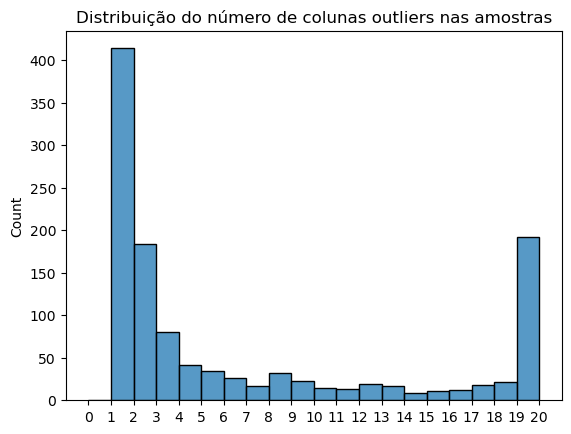

In [14]:
lengths=[]

for cols_list in liers.values():
    lengths.append(len(cols_list))

fig, ax = plt.subplots()
sns.histplot(lengths,ax=ax,bins=list(range(21)))
ax.set_title('Distribuição do número de colunas outliers nas amostras')
ax.set_xticks(list(range(21)))
plt.show()

Ou seja, a maioria das amostras que se enquadram como "liers" possuem somente uma coluna com valores absurdos. 

In [23]:
liers=tell_liers(eegs)

In [16]:
liers

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2781,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
corr=liers.corr(method='spearman',numeric_only=True)

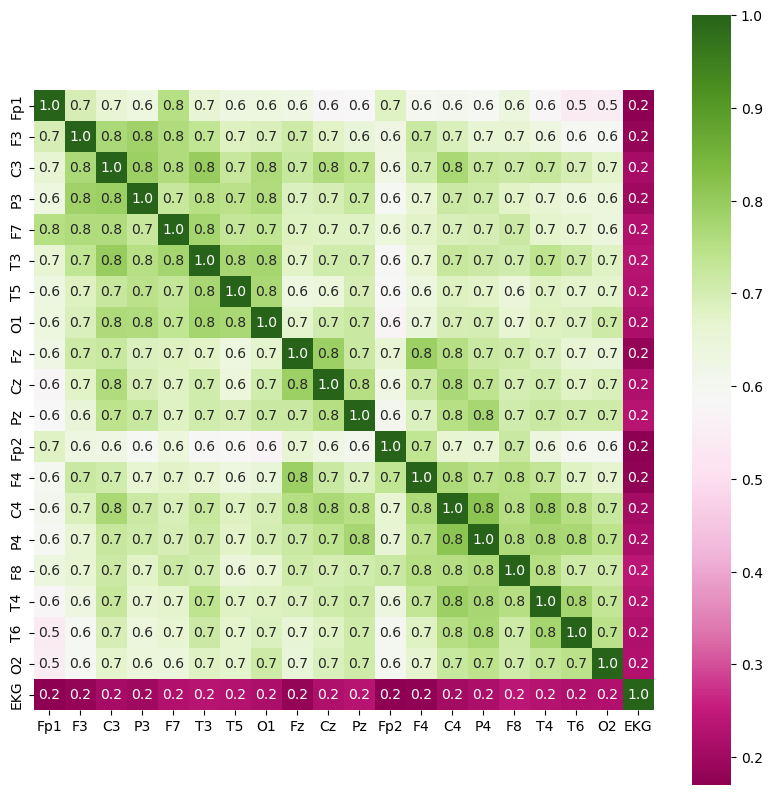

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap="PiYG",square=True,annot=True,fmt='.1f',ax=ax);

In [25]:
liers

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2781,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
def how_many_lies(liers,ax=None):
    
    # printa um histograma que descreve a distribuição do número de colunas outliers por amostra
    # este histograma nos conta quantas amostras possuem 1 coluna podre, 2 colunas podres, 3 colunas podres etc
    
    lengths=[]
    
    for index, row in liers.iterrows():
        
        lengths.append(row.sum())
        
    if ax==None:
        fig, ax = plt.subplots()
        
    sns.histplot(lengths,ax=ax,bins=list(range(21)))
    ax.set_xticks(list(range(21)))

In [44]:
def split_liers(liers, threshold=10, output='df'):
    
    # retorna um dataframe contendo as amostras que devem ser removidas e um dataframe com as amostras que devem ser tratadas
    
    big_liers=[]
    
    for index, row in liers.iterrows():
        
        if row.sum()>threshold:
            big_liers.append(index)
            
    print(f'Número de big liers: {len(big_liers)}')        
    print(f'Proporção de outliers: {len(big_liers)/liers.shape[0]}')
    
    to_drop=liers.iloc(big_liers)
    
    to_treat=liers.drop(big_liers)
    
    if output == 'df':   
        
        return to_drop, to_treat 
    
    elif output=='indices':
        
        return list(to_drop.index), list(to_treat.index)

In [36]:
def load_grouped(df, column='target',window=True):
    
    output = defaultdict(list)
    
    groups=df.groupby(column)
    
    for group_name, group_data in groups:
        
        print(f'Loading group {group_name}.')
        
        eegs, spects, labels = load_data(group_data.reset_index().drop('index', axis=1),window=window)
        
        output[group_name]+=[eegs, spects, labels]
        
    return output

In [53]:
with open('data_dict.pkl', 'rb') as f:
    data = pickle.load(f)

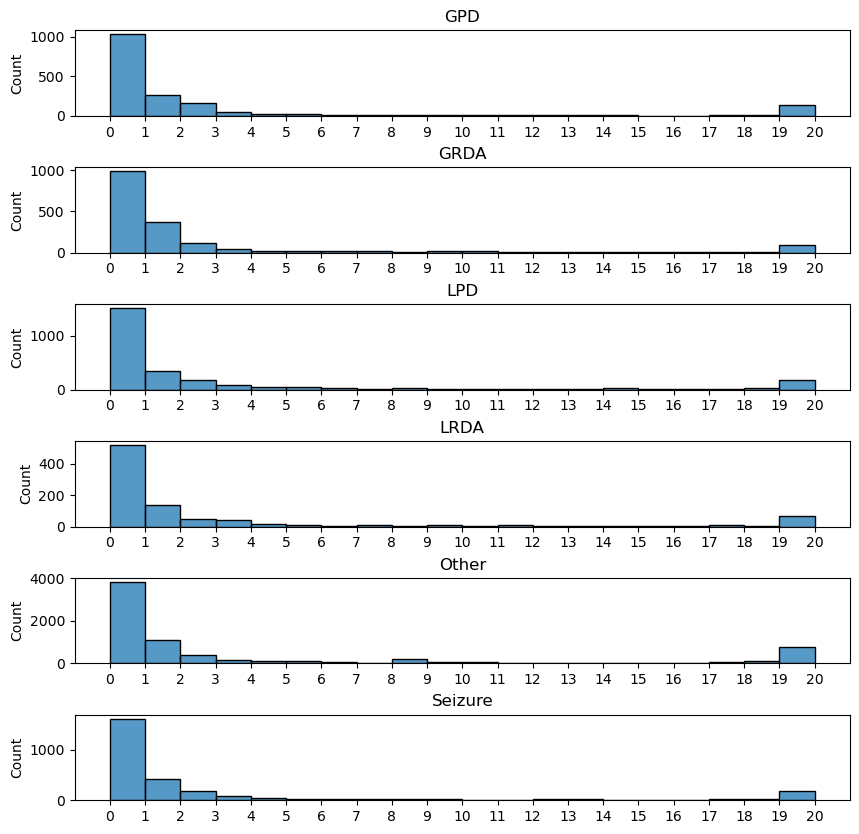

CPU times: total: 1min 6s
Wall time: 1min 17s


In [56]:
%%time

fig, ax = plt.subplots(6,1, figsize=(10,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.6)

for i, (label, dados) in enumerate(data.items()):
    
    liers=tell_liers(dados[0])
    
    how_many_lies(liers,ax=ax[i])
    
    ax[i].set_title(label)
    
plt.show()

In [57]:
data.keys()

dict_keys(['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure'])

In [60]:
data['GPD'][1].shape

(1787, 5, 400)